### Multi-Label Classification

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy # 모델 파라미터값 깊은 복사 (베스트 모델 저장을 위함)
import matplotlib.pyplot as plt

### Download the Dataset
### torchvision.datasets.MNIST
- torchvision.datasets 에 다양한 datasets 이 있음
- MNIST dataset (숫자 필기체)
  - 60,000 training 이미지, 10,000 test 이미지 (28 pixels X 28 pixels)
  - torchvision.datasets.MNIST(root='저장할폴더위치', train=True, download=True, transform=transforms.ToTensor())
    - train 이 True 이면 train 데이터, False 이면, test 데이터
    - download 가 True 이면, root 의 지정한 폴더에 데이터가 없으면, 다운로드 받음
    - transform=transforms.ToTensor() - 데이터 타입을 Tensor 형태로 변경m
    
- 참고: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [3]:
train_rawdata = datasets.MNIST(root = './data',
                               train = True,
                               download=True,
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data',
                               train = False,
                               download=True,
                               transform=transforms.ToTensor())
print(f'number of training data : {len(train_rawdata)}')
print(f'number of test data : {len(test_dataset)}')

number of training data : 60000
number of test data : 10000


### Validation dataset 분리
### torch.utils.data.Subset 으로 Validation dataset 생성
- torch.utils.data.Subset(데이터, 인덱스번호리스트) 로 인덱스 번호 리스트로 구성된 sub dataset 생성 가능
### dataset size 확인
### Mini-batch 생성

In [ ]:
VALIDATION_RATE = 0.2 #코드 실행 도중 변경되지 않기를 기대하는 값 즉 고정값은 변수를 대문자로
train_indices, val_indices, _, _ = train_test_split( # 필요한 두 개(train_indices, val_indices)만 받고, 나머지 두 개는 _로 버림
    range(len(train_rawdata)), # X index 번호 # 인덱스 번호 (예: 0,1,2,...,59999) -> 이름표 달아주기
    train_rawdata.targets, # y # 각 데이터의 정답 라벨 (예: 5,0,4,...)
    stratify=train_rawdata.targets, # 균등분포, 라벨 비율 맞추기
    test_size=VALIDATION_RATE # test dataset 비율
)

train_dataset = Subset(train_rawdata, train_indices) # 	전체 데이터 중 학습용으로 사용할 일부만 골라서 새로운 학습용 데이터셋을 만든다
validation_dataset = Subset(train_rawdata, val_indices)

print(f'train dataset size : {len(train_dataset)}\nvalidation dataset size : {len(validation_dataset)}\ntest dataset size: {len(test_dataset)}')

MINIBATCH_SIZE = 128 # Mini-batch 사이즈는 128 로 설정
# create batches
train_batches = DataLoader(train_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle=False)

train dataset size : 48000
validation dataset size : 12000
test dataset size: 10000


### 모델 정의
- Dropout 과 Batch Normalization 을 적용할 수 있는 별도 Layer 클래스 정의
- Linear -> LeakyReLU -> BatchNorm 을 반복하여 작성하는 부분을 별도 Layer 클래스로 정의하는 것임

### BatchNorm
- nn.BatchNorm1d(C):  텐서 형태가 (N, C) 또는 (N, C, L) 인 경우 적용
  - N 은 미니배치 사이즈, C 는 feature 의 수, L 은 데이터 길이
- nn.BatchNorm2d(C): 텐서 형태가 (N, C, H, W) 인 경우 적용
  - N 은 미니배치 사이즈, C 는 feature 의 수, H 와 W 는 height 와 width 를 의미함

  ### 별도 Layer 클래스 기반, 모델 정의
- 해당 모델도 별도 클래스로 정의하기로 함
- 마지막에는 Log softmax 값을 계산하기 위해, Linear 레이어를 추가해줘야 함

In [6]:
class Layer(nn.Module):
    def __init__(self, input_size, output_size, batch_norm=True, dropout = 0.5):
        self.input_size = input_size
        self.output_size = output_size
        self.batch_norm = batch_norm
        self.dropout = dropout

        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(), # LeakyReLU 기본값은 0.01
            self.apply_regularization()
        )

    def apply_regularization(self):
        if self.batch_norm:
            return nn.BatchNorm1d(self.output_size) # 입력 사이즈를 넣어줘야 함 (입력이 그 앞단의 Linear Layer 의 출력 사이즈가 됨)
        else:
            return nn.Dropout(self.dropout)
        
    def forward(self, x):
        return self.layer(x)
    

class DNNModel(nn.Module):
    def __init__(self, input_size, output_size, batch_norm=True, dropout = 0.5):
        super().__init__()

        self.layers = nn.Sequential(
            Layer(input_size, 256, batch_norm, dropout),
            Layer(256, 256, batch_norm, dropout),
            Layer(256, 128, batch_norm, dropout),
            nn.Linear(128, output_size),
            nn.LogSoftmax(dim=-1)
        )
    
    def forward(self, x):
        return self.layers(x)

### input, output, model 설정
- model 출력시 각 layer 를 간결히 확인할 수 있음
### loss function, optimizer 설정

In [11]:
input_dim = 28*28
output_dim = 10
model = DNNModel(input_dim, output_dim)
#model = DNNModel(input_dim, output_dim, False, 0.2)
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
model

DNNModel(
  (layers): Sequential(
    (0): Layer(
      (layer): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=-1)
  )
)

### Training Code 템플릿
- model : DNN 모델
- early_stop : Early Stopping 을 위해, 얼마의 epoch 까지 validation set 에 대한 loss 가 낮아지지 않을 경우, Early Stopping 을 할지의 하이퍼파라미터 값
- nb_epochs : 최대 epoch 
- progress_interval : 진행상황을 얼마의 epoch 마다 출력할지의 epoch 값

### 훈련 실행

In [ ]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf # np.inf는 무한대(infinity) 를 의미 -> 처음엔 아무 loss보다도 큰 값으로 시작해라. 그래야 처음 loss는 무조건 더 작아서 갱신됨

    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0 # 에폭마다 새롭게 train/validation 손실을 0부터 시작해서 누적 계산하겠다는 뜻
        
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:  # 미니배치 단위로 반복
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1)) # 입력 펼치기 → 이미지(28x28)를 1D 벡터(784차원) 로 펼쳐줍니다.
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_batches) # 전체 평균 loss = 누적합 / 배치 수
        train_losses.append(train_loss)      
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1] # 더 낮은 validation loss 발견 (이번 epoch의 검증 손실)
            lowest_epoch = epoch # 몇 번째 epoch인지 기억
            best_model = deepcopy(model.state_dict()) # 그때 모델 저장
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch: #patience(=early_stop)만큼 기다렸다가 그래도 개선 안 되면 break로 멈춤 (early stopping)
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0: #  일정 간격마다 지금 학습 상태를 출력
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model) # 학습이 끝나면, 가장 좋은 성능을 냈던 모델(best_model)을 다시 불러옴        
    return model, lowest_loss, train_losses, valid_losses

nb_epochs = 30 
progress_interval = 3
early_stop = 10

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.2127951991558075 0.11663479029022633 0.11663479029022633 0 0
0.045509969788293046 0.09105205649331688 0.08074932317546707 2 3
0.02610008073815455 0.08517369286137376 0.07656630779557089 5 6
0.019624504530026267 0.07064928632586244 0.07064928632586244 9 9
0.014718728932319208 0.08047545038441077 0.07064928632586244 9 12
0.011904219426602747 0.08146071591800912 0.07064928632586244 9 15
0.008073473060367785 0.08506031888611416 0.07064928632586244 9 18
Early Stopped 20 epochs


- 0.008073473060367785 (train_loss) 0.08506031888611416 (valid_loss) 0.07064928632586244 (lowest_loss) 9 (지금까지 가장 낮은 validation loss가 나왔던 에폭 번호) 18 ( 현재 몇 번째 에폭인지)

### 테스트셋 기반 Evaluation

.ne() : 예측 ≠ 정답인 위치 → True (틀림)

.nonzero() : 틀린 인덱스 추출

[:, 0] : 1차원으로 정리

.tolist() : 리스트로 변환


In [ ]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list() # 테스트 손실값 누적용, 정답 개수, 틀린 예시를 저장할 변수들을 초기화

model.eval() #  모델을 평가 모드로 설정
with torch.no_grad():# 평가할 때는 gradient 계산이 필요 없으니 꺼줌
    for x_minibatch, y_minibatch in test_batches: # 테스트셋을 미니배치 단위로 반복
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1)) # 28x28 이미지를 펼쳐서 1D 벡터(784차원)로 만든 뒤 모델에 입력
        test_loss += loss_func(y_test_pred, y_minibatch) # 예측 결과와 실제 정답을 비교해서 누적하며 loss 계산
        pred = torch.argmax(y_test_pred, dim=1) #  모델 출력 중 가장 확신하는 클래스(index) 를 선택
        correct += pred.eq(y_minibatch).sum().item() # 예측(pred)과 실제 정답(y_minibatch)을 비교해서 맞춘 개수 누적
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist() # 틀린 샘플의 인덱스를 뽑기
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index]) # 입력 이미지
            wrong_preds.append(pred[index]) # 모델 예측
            actual_preds.append(y_minibatch[index]) # 실제 정답
            
test_loss /= len(test_batches.dataset) # 평균 loss 출력 (소수점 4자리까지)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))

Average Test Loss: 0.0006
Accuracy: 9808/10000 (98.08%)


### incorrect data 만 확인해보기

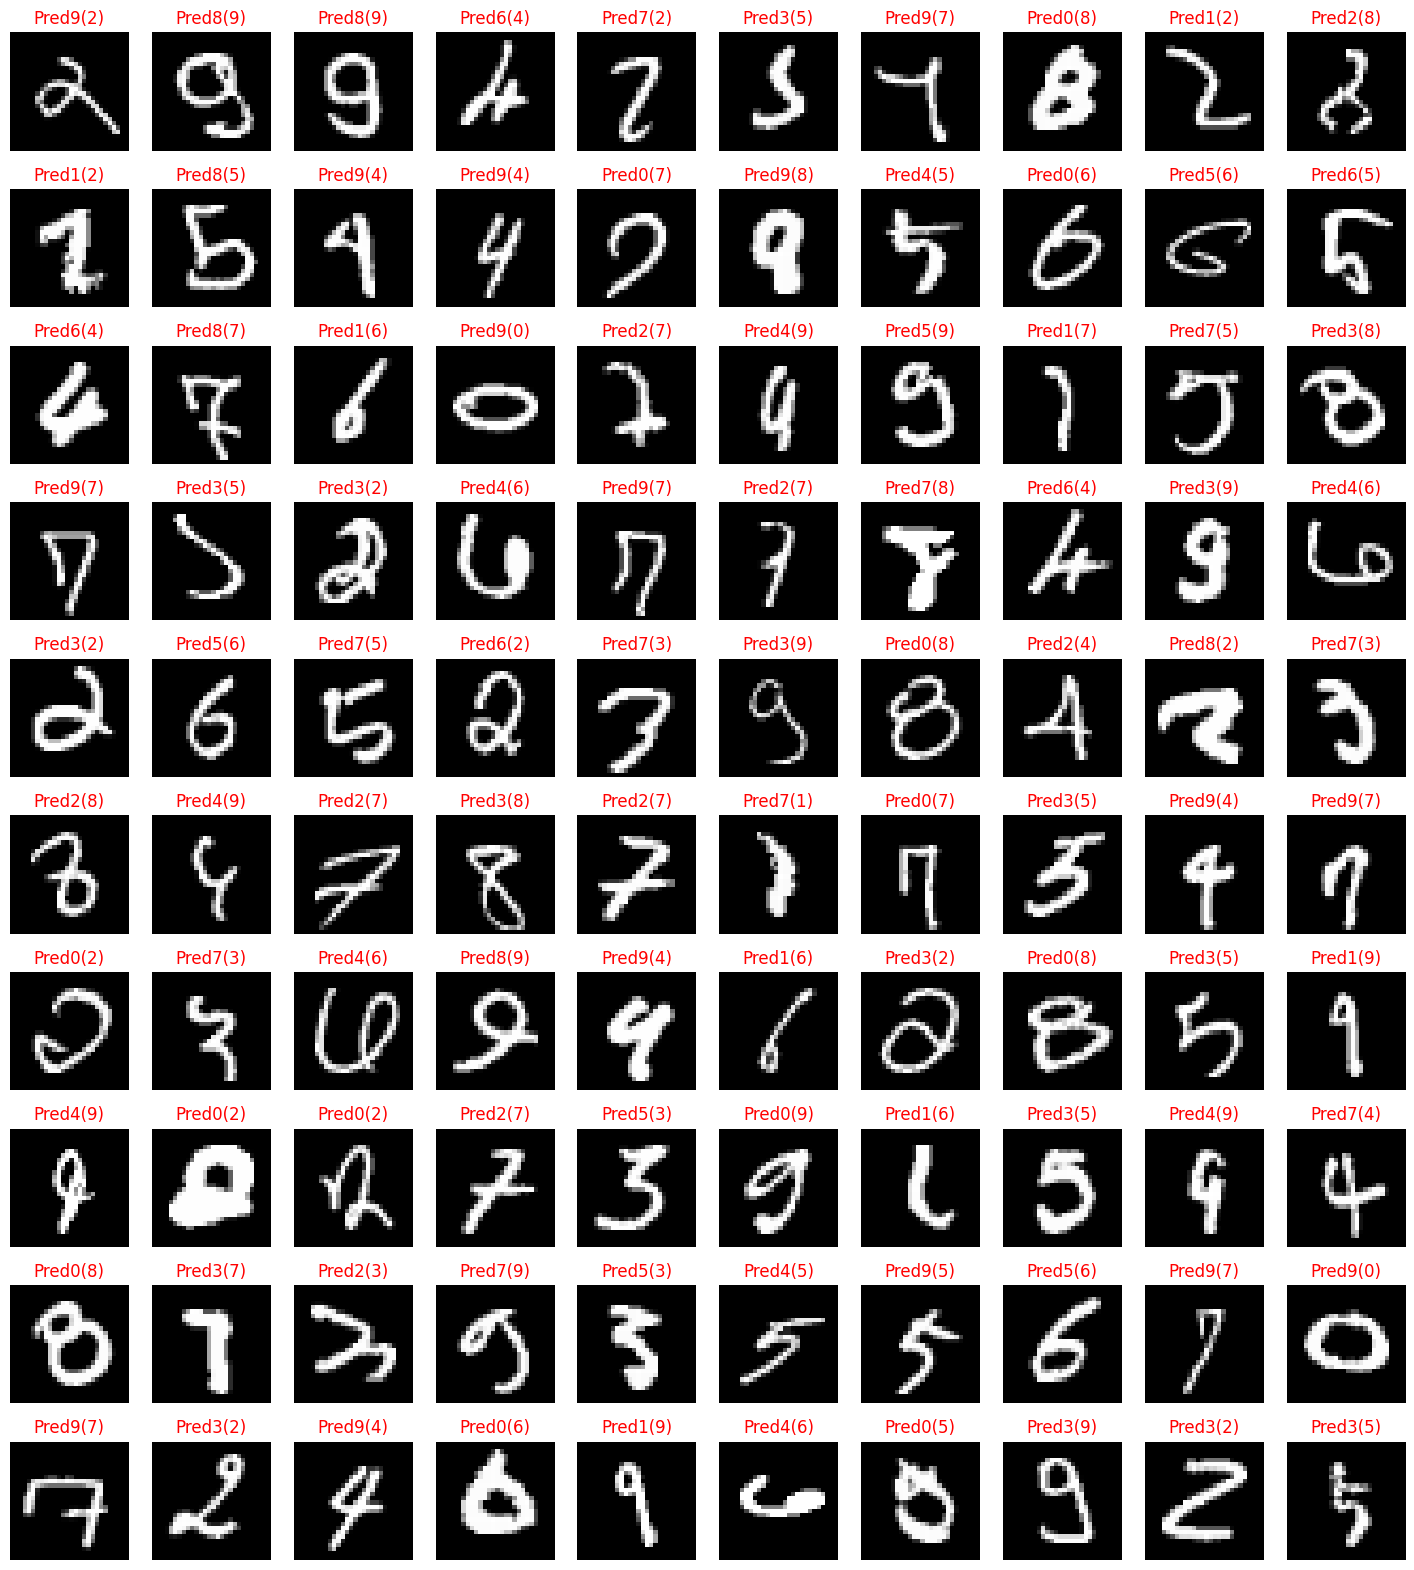

In [15]:
# incorrect 데이터 중, 100개 이미지만 출력해보기
import matplotlib.pyplot as plt
# 주피터 노트북에서 그림을 주피터 노트북 내에 표시하도록 강제하는 명령
%matplotlib inline 

plt.figure(figsize=(18 , 20))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy( ).reshape(28,28), cmap = "gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')